In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator, MultipleLocator

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]


In [2]:
proj_path = "/home/4cv/project/gc_openPMD-viewer/"

df_path = proj_path + "results/final/small.csv"
df = pd.read_csv(df_path, header=[0])

In [3]:
print("Before Sampling, each group size:")
print(df.groupby(['target_percentage', 'select_set']).size() / 10)

number_of_each_group = 10
target_percentage = "0.01%"
df = df[df['test_type']==1]
# Filter DataFrame by target_percentage
df_filtered = df[df['target_percentage'].isin(["0.01%", "10.00%"])]
# print(df_filtered.groupby(['target_percentage', 'select_set']).size() / 10)
# Group by select_set and get unique envelope values for each group
unique_envelopes = df_filtered.groupby('select_set')['envelope'].unique().reset_index()

# Rename columns for clarity
unique_envelopes.columns = ['select_set', 'unique_envelopes']

# print the number of unique envelopes for each group
# for i in range(number_of_each_group):
#     print(f"Group {i+1} has {len(unique_envelopes['unique_envelopes'][i])} unique envelopes.")

# Function to sample envelopes
# def sample_envelopes(envelopes, n):
#     return list(envelopes.sample(n=min(n, len(envelopes))))

# Apply the sampling to each group
# unique_envelopes['sampled_envelopes'] = unique_envelopes['unique_envelopes'].apply(lambda x: list(pd.Series(x).sample(number_of_each_group)))
# # unique_envelopes['sampled_envelopes'] = unique_envelopes['unique_envelopes'].apply(lambda x: sample_envelopes(pd.Series(x), number_of_each_group))
#
# # Clean up the DataFrame by dropping the original unique envelopes column
# for i in range(number_of_each_group):
#     print(f"Group {i+1} has {len(unique_envelopes['sampled_envelopes'][i])} sampled envelopes.")

unique_envelopes['sampled_envelopes'] = unique_envelopes['unique_envelopes']

# Explode the sampled_envelopes into separate rows
exploded_unique_envelopes = unique_envelopes.explode('sampled_envelopes')

# Merge the exploded_unique_envelopes back to df_filtered to keep only relevant rows
filtered_df = df_filtered.merge(exploded_unique_envelopes[['select_set', 'sampled_envelopes']],
                                left_on=['select_set', 'envelope'],
                                right_on=['select_set', 'sampled_envelopes'])

# Drop the 'sampled_envelopes' column as it's now redundant
filtered_df = filtered_df.drop(columns='sampled_envelopes')

print("")
print(filtered_df.groupby(['target_percentage', 'select_set']).size())

filtered_df = filtered_df[['target_percentage', 'select_set', 'test_type', 'query_index_time_elapsed', 'remove_duplication_time_elapsed',
                           'sort_block_metadata_time_elapsed', 'find_optimal_read_solution_time_elapsed',
                           'get_target_data_time_elapsed', 'get_support_data_time_elapsed',
                           'data_calculation_time_elapsed', 'data_apply_select_time_elapsed', 'apply_particle_level_select_array_time_elapsed', 'total_time_elapsed', 'query_result_size', 'chunk_range_size']]

filtered_df['indexing'] = filtered_df['query_index_time_elapsed'] + df['remove_duplication_time_elapsed'] + df['sort_block_metadata_time_elapsed'] + df['find_optimal_read_solution_time_elapsed']
filtered_df['IO_time'] = filtered_df['get_target_data_time_elapsed'] + df['get_support_data_time_elapsed']
filtered_df['calculation'] = filtered_df['data_calculation_time_elapsed'] + df['data_apply_select_time_elapsed'] + df['apply_particle_level_select_array_time_elapsed']

filtered_df = filtered_df[['target_percentage', 'select_set', 'indexing', 'IO_time', 'calculation', 'total_time_elapsed', 'query_result_size', 'chunk_range_size']]

# Group by select_set and test_type, then compute the average value
averaged_df = filtered_df.groupby(['target_percentage', 'select_set']).mean().reset_index()


# only keep the select_set with specific values: ('ux',),  ('ux','uy'),  ('ux','uy','uz'),  ('ux','uy','uz','x'), ('ux','uy','uz','x','y'), ('ux','uy','uz','x','y','z')
averaged_df = averaged_df[averaged_df['select_set'].isin(["('ux',)", "('ux','uy')", "('ux','uy','uz')", "('ux','uy','uz','x')", "('ux','uy','uz','x','y')", "('ux','uy','uz','x','y','z')"])]

# a new column to indicate the length of select_set
averaged_df['select_set_length'] = averaged_df['select_set'].apply(lambda x: len(eval(x)))

# sort by select_set_length
averaged_df = averaged_df.sort_values('select_set_length')
print("")
print(averaged_df.groupby(['target_percentage', 'select_set']).size())
# print(averaged_df)


Before Sampling, each group size:
target_percentage  select_set                  
0.01%              ('ux','uy')                     15.0
                   ('ux','uy','uz')                15.0
                   ('ux','uy','uz','x')            15.0
                   ('ux','uy','uz','x','y')        15.0
                   ('ux','uy','uz','x','y','z')    15.0
                   ('ux','uy','x','y')             15.0
                   ('ux',)                         15.0
                   ('x','y')                       15.0
                   ('x','y','z')                   15.0
                   ('x',)                          15.0
0.10%              ('ux','uy')                     15.0
                   ('ux','uy','uz')                15.0
                   ('ux','uy','uz','x')            15.0
                   ('ux','uy','uz','x','y')        15.0
                   ('ux','uy','uz','x','y','z')    15.0
                   ('ux','uy','x','y')             15.0
                   ('u

In [4]:
global_tick_fontsize = 20
global_label_fontsize = 24
global_annotation_fontsize = 20
global_legend_fontsize = 18

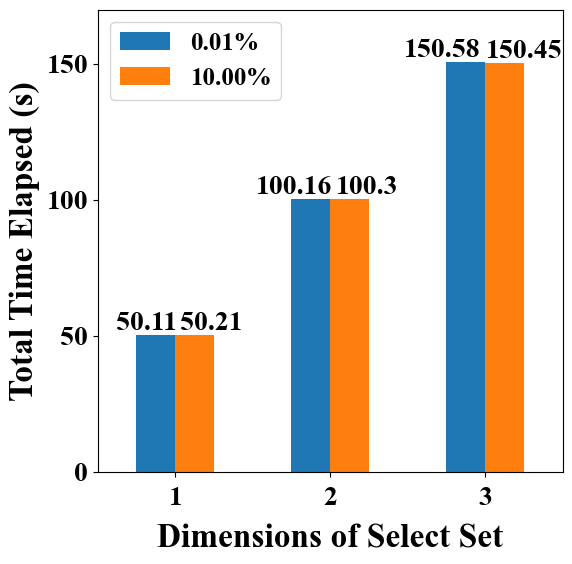

In [32]:
# only keep the test_type with specific values: 1 and 25\
# plot_df = averaged_df[averaged_df['test_type'].isin([1, 25])]
plot_df = averaged_df

plot_df = plot_df[plot_df['select_set_length'] <= 3]

fig, ax = plt.subplots()
# set figure size
fig.set_size_inches(6, 6)

# the value difference between test_type 1 and 25 is too large, so we use log scale
# plot_df['total_time_elapsed'] = plot_df['total_time_elapsed'].apply(lambda x: np.log10(x))

# log for query_result_size and chunk_range_size
# plot_df['query_result_size'] = plot_df['query_result_size'].apply(lambda x: np.log10(x))
# plot_df['chunk_range_size'] = plot_df['chunk_range_size'].apply(lambda x: np.log10(x))


# plot grouped bar chart, x is select_set_length, y is time_elapsed, grouped by test_type
plot_df.pivot(index='select_set_length', columns='target_percentage', values='total_time_elapsed').plot(kind='bar', ax=ax)
legend = ax.legend(title='', loc='upper left', fontsize=global_legend_fontsize)

for text in legend.get_texts():
    text.set_fontweight('bold')

# mark the number on the top of each bar before log
for i, p in enumerate(ax.patches):
    if i == 0:
    # ax.annotate(str(round(10**p.get_height(), 2)), (p.get_x() + 0.02, p.get_height() + 0.05), fontsize=global_annotation_fontsize, fontweight='bold')
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() - 0.13, p.get_height() + 2), fontsize=global_annotation_fontsize, fontweight='bold')
    elif i == 1:
    # ax.annotate(str(round(10**p.get_height(), 2)), (p.get_x() + 0.02, p.get_height() + 0.05), fontsize=global_annotation_fontsize, fontweight='bold')
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() - 0.23, p.get_height() + 2), fontsize=global_annotation_fontsize, fontweight='bold')
    elif i == 2:
    # ax.annotate(str(round(10**p.get_height(), 2)), (p.get_x() + 0.02, p.get_height() + 0.05), fontsize=global_annotation_fontsize, fontweight='bold')
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() - 0.28, p.get_height() + 2), fontsize=global_annotation_fontsize, fontweight='bold')
    elif i == 5:
    # ax.annotate(str(round(10**p.get_height(), 2)), (p.get_x() + 0.02, p.get_height() + 0.05), fontsize=global_annotation_fontsize, fontweight='bold')
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x(), p.get_height() + 2), fontsize=global_annotation_fontsize, fontweight='bold')
    else:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + 0.03, p.get_height() + 2), fontsize=global_annotation_fontsize, fontweight='bold')

plt.xticks(rotation=0)
# plt y range
plt.ylim(0, 170)
# x label
plt.xlabel("Dimensions of Select Set", fontsize=global_label_fontsize, labelpad=10, fontweight='bold')
# y label
plt.ylabel("Total Time Elapsed (s)", fontsize=global_label_fontsize, fontweight='bold')

# current_values = plt.gca().get_yticks()
# plt.gca().yaxis.set_major_formatter(FuncFormatter(exp_formatter))
plt.gca().yaxis.set_major_locator(MultipleLocator(50))
# plt.gca().set_yticklabels([str(int(pow(10, y))) for y in plt.gca().get_yticks()])

# Adjust tick label fontsize
plt.gca().tick_params(axis='y', labelsize=global_tick_fontsize)  # Adjust label size as needed
plt.gca().tick_params(axis='x', labelsize=global_tick_fontsize, pad=7)

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# plot 'query_result_size', 'chunk_range_size' in the same figure as the plot and use right y-axis with test_type = 25
'''
ax2 = ax.twinx()
# ax2.set_xlim((ax.get_xlim()))
# with point * as marker
# select_set_length is the x-axis and start from 0
plot_df['select_set_length'] = plot_df['select_set_length'] - 1
# plot_df[averaged_df['test_type'] == 25].pivot(index='select_set_length', columns='test_type', values='query_result_size').plot(kind='line', ax=ax2, color='blue', marker='*', markersize=10)
plot_df[averaged_df['test_type'] == 25].pivot(index='select_set_length', columns='target_percentage', values='chunk_range_size').plot(kind='line', ax=ax2, color='red', marker='o', markersize=8, linewidth=2)
plt.ylim(0, 3400)

# y label
plt.ylabel("I/O Numbers of ABC Indexing", fontsize=global_label_fontsize, rotation=270, labelpad=25, fontweight='bold')
current_values = plt.gca().get_yticks()
plt.gca().yaxis.set_major_locator(MultipleLocator(1000))
# plt.gca().yaxis.set_major_formatter(FuncFormatter(exp_formatter))
plt.gca().set_yticklabels([f"{int(y / 1000)}k" if y != 0 else "0" for y in plt.gca().get_yticks()])
# Adjust tick label fontsize
plt.gca().tick_params(axis='y', labelsize=global_tick_fontsize)  # Adjust label size as needed

# Remove the legend
plt.gca().get_legend().remove()

plt.yticks(fontweight='bold')
'''
plt.savefig(proj_path + "plot/final/motivation_small_percentage.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()
print()